In [22]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
## 1. Data Loading and Preprocessing

# Define dataset paths (update these paths according to your directory structure)
train_dir = 'intel-image-classification/seg_train/seg_train'
test_dir = 'intel-image-classification/seg_test/seg_test'

In [25]:
# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
NUM_CLASSES = 6  # buildings, forest, glacier, mountain, sea, street

In [26]:
# Create ImageDataGenerator with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of training data for validation
)

In [27]:
# For test data, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # This is for training data
)

Found 11230 images belonging to 6 classes.


In [29]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # This is for validation data
)

Found 2804 images belonging to 6 classes.


In [30]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix and metrics
)

Found 3000 images belonging to 6 classes.


In [31]:
# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

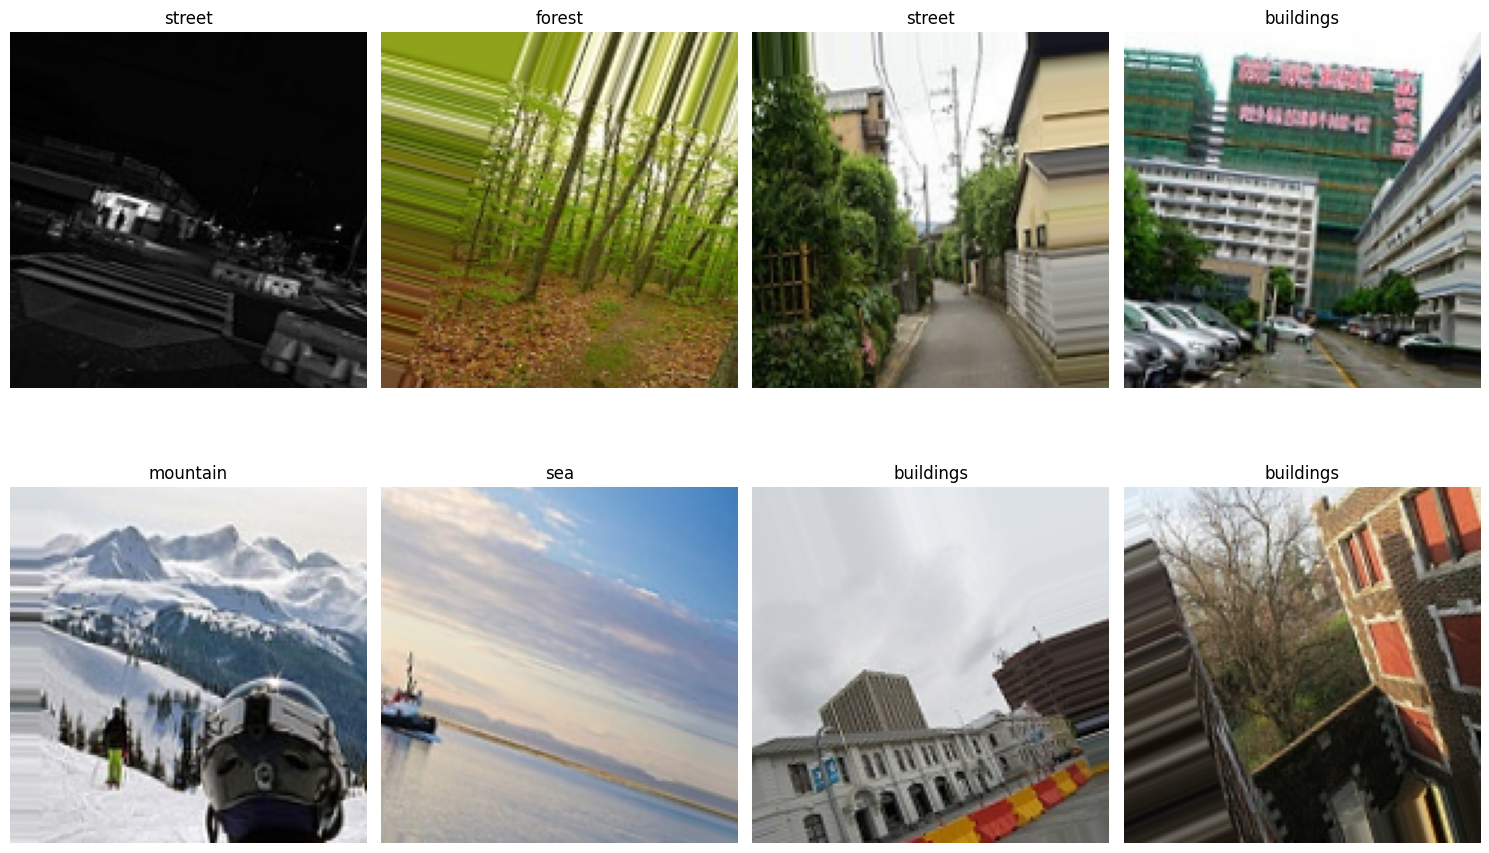

In [32]:
# Display some sample images with labels
def plot_sample_images(generator, num_images=8):
    images, labels = next(generator)
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

In [56]:
## 2. Model Building

# Create CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    
    # Output layer
    Dense(NUM_CLASSES, activation='softmax')
])

d:\AI_Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [37]:
# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [38]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/30


d:\AI_Project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 261s 707ms/step - accuracy: 0.4405 - loss: 1.4235 - val_accuracy: 0.6038 - val_loss: 1.0281
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.5625 - loss: 0.9366 - val_accuracy: 0.5500 - val_loss: 0.9706
Epoch 3/30


d:\AI_Project\venv\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 357ms/step - accuracy: 0.6003 - loss: 1.0084 - val_accuracy: 0.6947 - val_loss: 0.8337
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - accuracy: 0.6875 - loss: 0.9418 - val_accuracy: 0.7500 - val_loss: 0.8193
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 130s 368ms/step - accuracy: 0.6740 - loss: 0.8675 - val_accuracy: 0.7177 - val_loss: 0.7870
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.6562 - loss: 0.7885 - val_accuracy: 0.6500 - val_loss: 0.8703
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 148s 419ms/step - accuracy: 0.7276 - loss: 0.7451 - val_accuracy: 0.7561 - val_loss: 0.6620
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.9688 - loss: 0.3705 - val_accuracy: 0.7500 - val_loss: 0.6352
Epoch 9/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 391ms/step - accuracy: 0.7369 - loss: 0.7178 - val_accuracy: 0.7705 - val_loss: 0.6294
Epoch 10/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.9062 - loss: 0.3290 - va

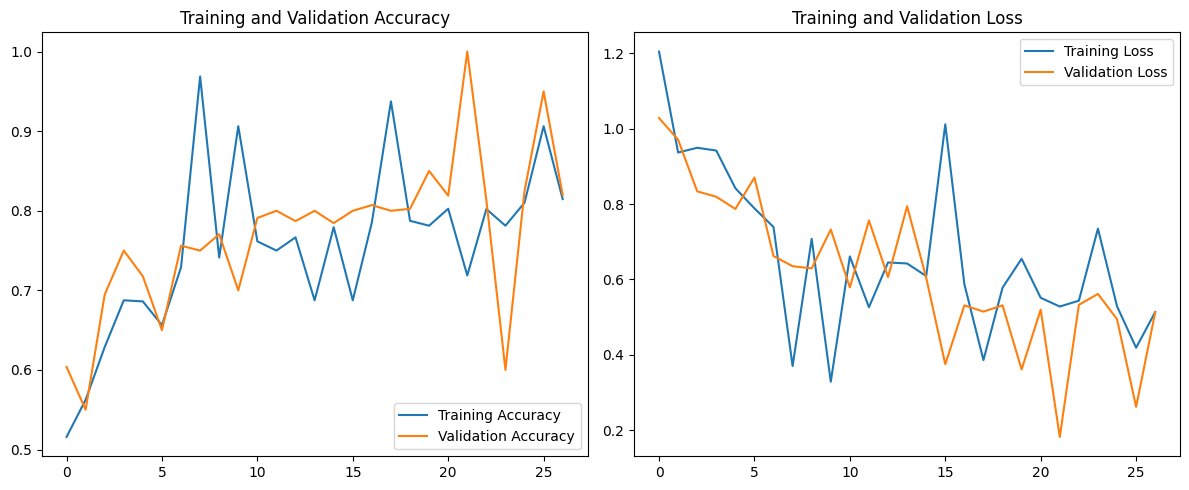

In [39]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))  # Use actual number of epochs run
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [40]:
## 4. Model Evaluation

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 325ms/step - accuracy: 0.8734 - loss: 0.3769

Test accuracy: 0.8413
Test loss: 0.4585


In [41]:
# Generate predictions
test_generator.reset()  # Reset generator to ensure we start from the beginning
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


In [42]:
# Get true classes
true_classes = test_generator.classes

In [43]:
# Classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   buildings       0.73      0.89      0.80       437
      forest       0.98      0.96      0.97       474
     glacier       0.82      0.79      0.80       553
    mountain       0.82      0.76      0.79       525
         sea       0.86      0.80      0.83       510
      street       0.87      0.86      0.86       501

    accuracy                           0.84      3000
   macro avg       0.84      0.85      0.84      3000
weighted avg       0.85      0.84      0.84      3000



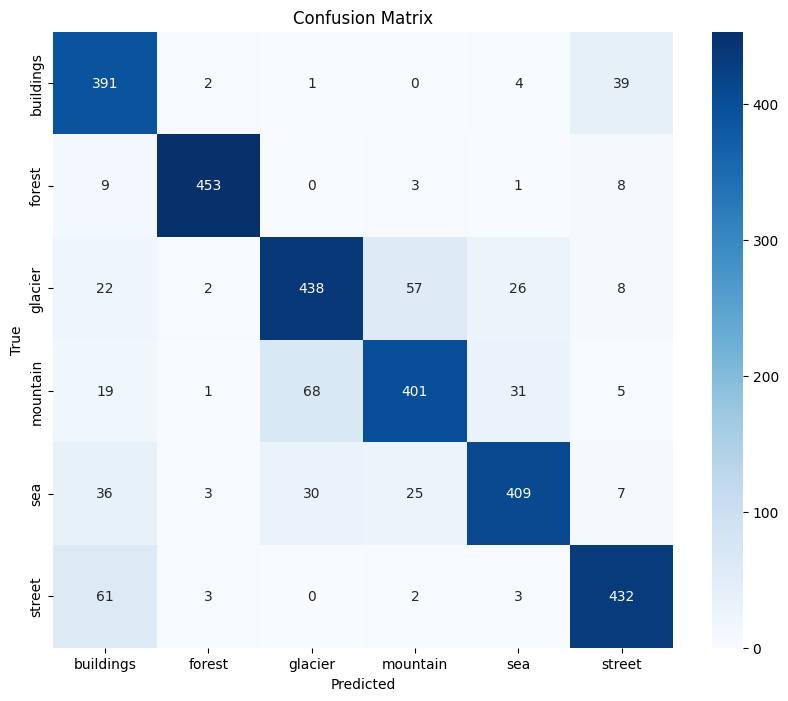

In [44]:
# Confusion matrix
def plot_confusion_matrix(true_classes, predicted_classes, class_names):
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(true_classes, predicted_classes, class_names)

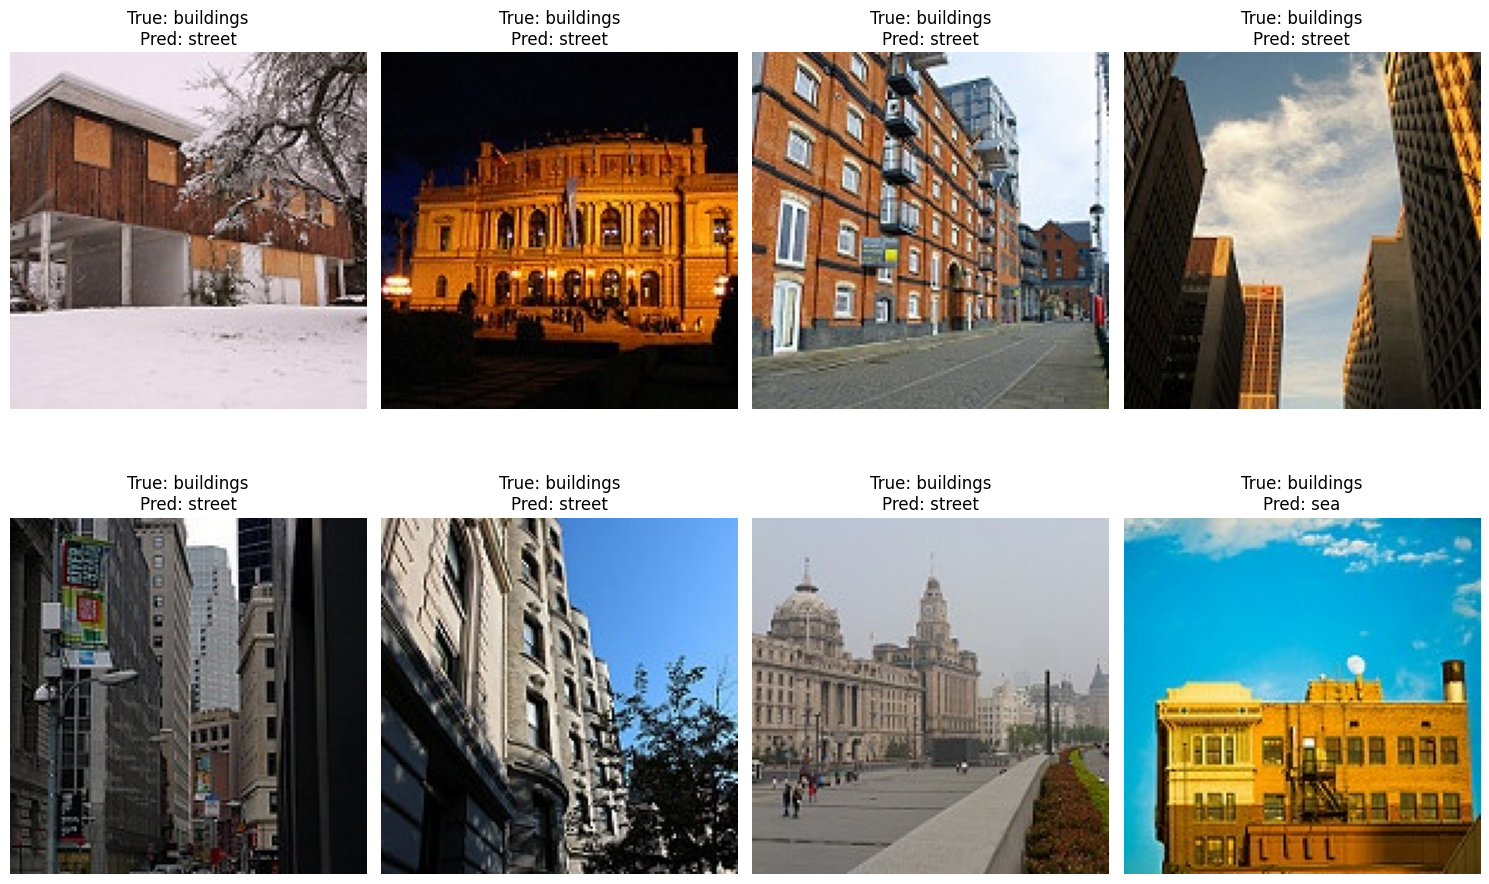

In [46]:
## Task 3: Visualization and Interpretation

# 1. Display misclassified images
def plot_misclassified_images(generator, true_classes, predicted_classes, class_names, num_images=8):
    misclassified = np.where(predicted_classes != true_classes)[0]
    
    # Get all images from the generator
    generator.reset()
    images = []
    labels = []
    for _ in range(len(generator)):
        img_batch, label_batch = next(generator)
        images.extend(img_batch)
        labels.extend(label_batch)
        if len(images) >= len(true_classes):
            break
    
    images = np.array(images)
    labels = np.array(labels)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(misclassified[:num_images]):
        if idx >= len(images):  # Safety check
            continue
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[idx])
        plt.title(f'True: {class_names[true_classes[idx]]}\nPred: {class_names[predicted_classes[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified_images(test_generator, true_classes, predicted_classes, class_names)

In [79]:
model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))

In [80]:
# 2. Visualize feature maps from first convolutional layer
def visualize_feature_maps(model, img_path, layer_index=0):
    # Create a model that outputs the first conv layer's activations
    layer_output = model.layers[layer_index].output
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_output)
    
    # Load and preprocess a single image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Get activations
    activations = activation_model.predict(img_array)
    
    # Visualize the feature maps
    plt.figure(figsize=(15, 10))
    num_filters = activations.shape[-1]
    cols = 8
    rows = int(np.ceil(num_filters / cols))
    
    for i in range(num_filters):
        plt.subplot(rows, cols, i+1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


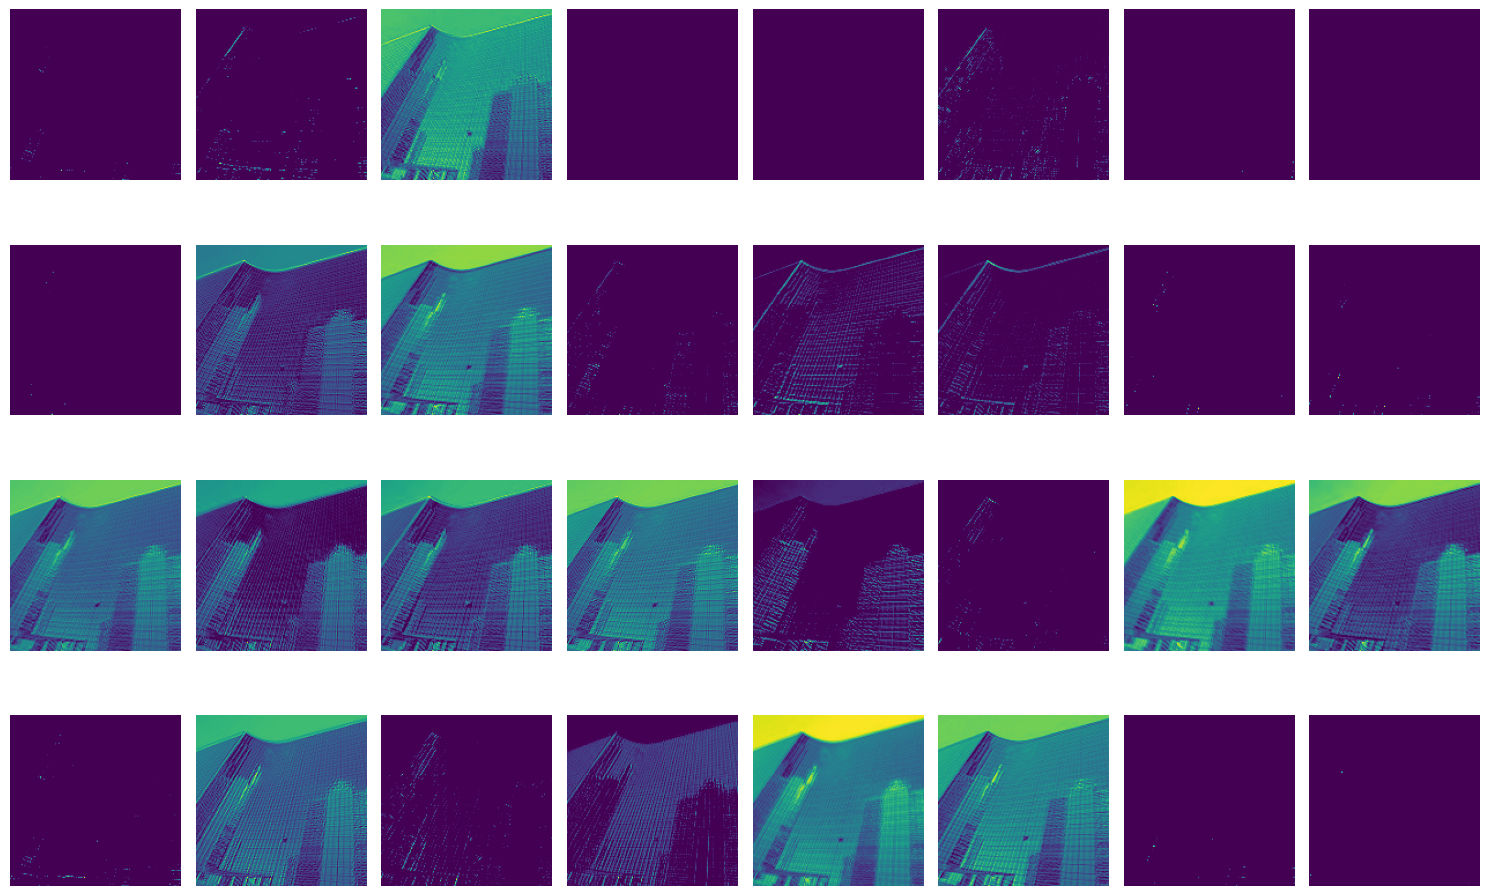

In [81]:
image_path = "intel-image-classification/seg_test/seg_test/buildings/20828.jpg"
visualize_feature_maps(model, image_path, layer_index=0)